<a href="https://colab.research.google.com/github/antoinedemathelin/ecas2025-transfer-learning/blob/main/SupervisedTL_synth_GaussCL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Supervised transfer learning on synthetic data</h1>

In [ ]:
import sys
import copy
import pandas as pd
import  numpy as np
import sklearn.metrics as metr
import sklearn.model_selection as select
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [ ]:
#!pip install adapt
#import adapt._tree_utils as ut
from adapt.parameter_based import TransferTreeClassifier, TransferForestClassifier
from adapt.parameter_based  import TransferTreeSelector, TransferForestSelector

<h2>Supervised transfer learning on linear models </h2><a name="lin_m"></a>

<h3>Supervised transfer learning for 1-d regression : </h3><a name="reg"></a>

#### Example 1 : affine regression function with normal distribution <a name="ex1_reg"></a>

In [ ]:
from plot_utils import plot_dots, plot_dec_func, show_reg1d, plot_1d_func, plot_dec_func_explicite


<h3>Example 2 : decision tree for two gaussian clusters classification </h3><a name="dt_2clust"></a>

### Unique decision tree / One gaussian cluster per class

In [ ]:
np.random.seed(0)

# Generate training source data
ns = 200
ns_perclass = ns // 2
mean_1 = (1, 1)
var_1 = np.diag([1, 1])
mean_2 = (3, 3)
var_2 = np.diag([2, 2])
Xs = np.r_[np.random.multivariate_normal(mean_1, var_1, size=ns_perclass),
           np.random.multivariate_normal(mean_2, var_2, size=ns_perclass)]
ys = np.zeros(ns)
ys[ns_perclass:] = 1

ns_test = 1000
ns_test_perclass = ns_test // 2
Xs_test = np.r_[np.random.multivariate_normal(mean_1, var_1, size=ns_test_perclass),
                np.random.multivariate_normal(mean_2, var_2, size=ns_test_perclass)]
ys_test = np.zeros(ns_test)
ys_test[ns_test_perclass:] = 1

# Generate training target data
nt = 50

# balanced
nt_0 = nt // 2

mean_1 = (6, 3)
var_1 = np.diag([4, 1])
mean_2 = (5, 5)
var_2 = np.diag([1, 3])
Xt = np.r_[np.random.multivariate_normal(mean_1, var_1, size=nt_0),
           np.random.multivariate_normal(mean_2, var_2, size=nt - nt_0)]
yt = np.zeros(nt)
yt[nt_0:] = 1
# Generate testing target data
nt_test = 1000
nt_test_perclass = nt_test // 2
Xt_test = np.r_[np.random.multivariate_normal(mean_1, var_1, size=nt_test_perclass),
                np.random.multivariate_normal(mean_2, var_2, size=nt_test_perclass)]
yt_test = np.zeros(nt_test)
yt_test[nt_test_perclass:] = 1

In [ ]:
np.random.seed(0)

methods = [
    'relab',
    'ser',
    'strut'
]
labels = [
    'relab',
    '$SER$',
    '$STRUT$'
]

MAX_DEPTH = 5
clf_source = DecisionTreeClassifier(max_depth=MAX_DEPTH)
clf_source.fit(Xs, ys)
clf_target = DecisionTreeClassifier(max_depth=MAX_DEPTH)
clf_target.fit(Xt, yt)

score_src_src = clf_source.score(Xs_test, ys_test)
score_src_trgt = clf_source.score(Xt_test, yt_test)
print('Testing score Source model on Source data: {:.3f}'.format(score_src_src))
print('Testing score Source model on Target data: {:.3f}'.format(score_src_trgt))

clfs = []
scores = []
auc_scores = []

for m,method in enumerate(methods):

    clf_transfer = copy.deepcopy(clf_source)

    if method == 'relab':
        transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="")
        transferred_model.fit(Xt,yt)
        clf_relab = copy.deepcopy(transferred_model)

    if method == 'ser':
        transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="ser")
        transferred_model.fit(Xt,yt)
        clf_ser = copy.deepcopy(transferred_model)

    if method == 'strut':
        transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="strut")
        transferred_model.fit(Xt,yt)
        clf_strut = copy.deepcopy(transferred_model)


    score = transferred_model.estimator_.score(Xt_test, yt_test)
    yp = transferred_model.estimator_.predict_proba(Xt_test)[:,1]
    auc_score = roc_auc_score(yt_test,yp)

    print('Testing score transferred model ({}) : {:.3f}'.format(method, score))
    print('Testing ROC AUC score transferred model ({}) : {:.3f}'.format(method, auc_score))

    clfs.append(transferred_model.estimator_)
    scores.append(score)
    auc_scores.append(auc_score)


Testing score Source model on Source data: 0.832
Testing score Source model on Target data: 0.513
Testing score transferred model (relab) : 0.676
Testing ROC AUC score transferred model (relab) : 0.675
Testing score transferred model (ser) : 0.713
Testing ROC AUC score transferred model (ser) : 0.713
Testing score transferred model (strut) : 0.685
Testing ROC AUC score transferred model (strut) : 0.734


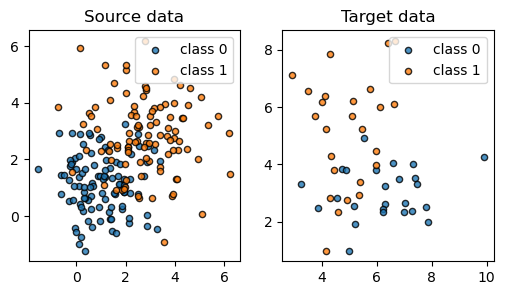

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6, 3))
plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

NameError: name 'score_src_tgt' is not defined

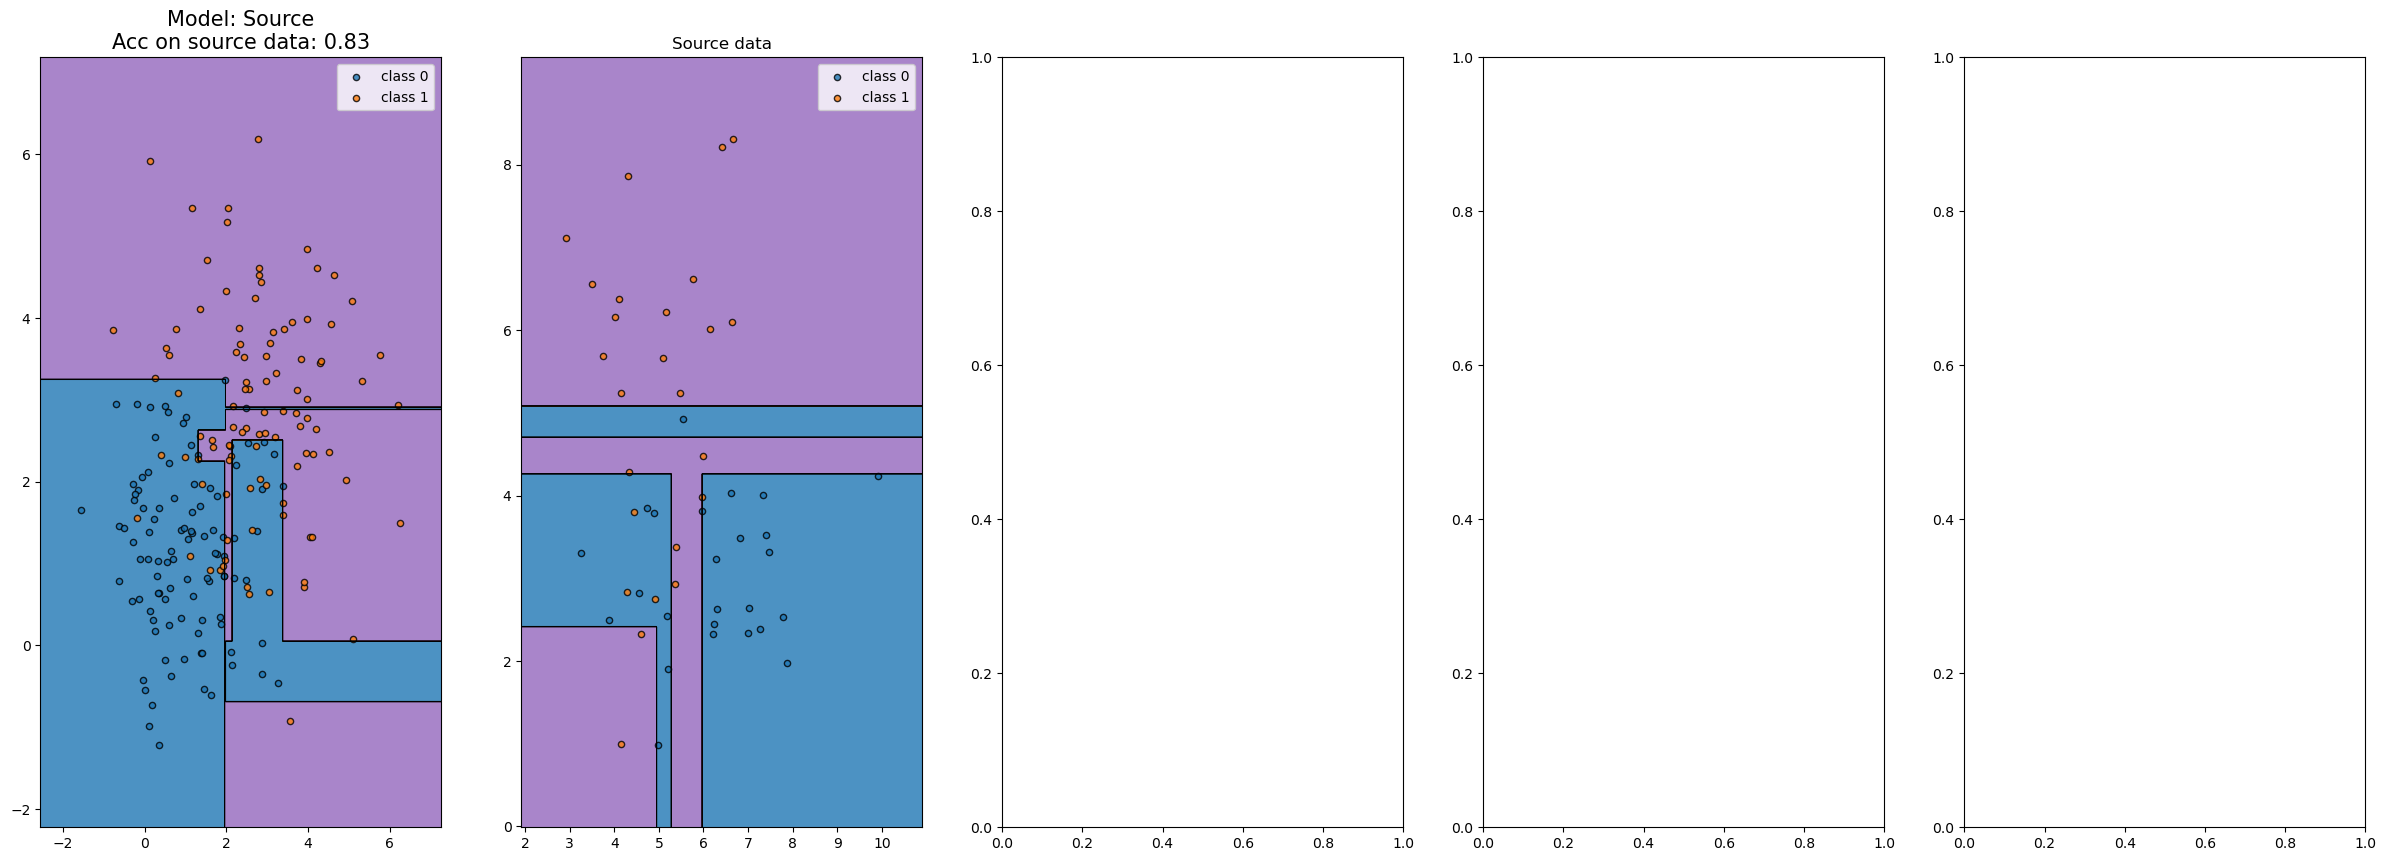

In [ ]:
# Plot decision functions

plot_step = 0.01

fig, ax = plt.subplots(nrows=1, ncols=len(methods) + 2, figsize=(30, 10))

x_min, x_max = Xs[:, 0].min() - 1, Xs[:, 0].max() + 1
y_min, y_max = Xs[:, 1].min() - 1, Xs[:, 1].max() + 1

plot_dec_func(ax[0], clf_source,  x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source model')
plot_dots(ax[0],Xs,ys, title='Source data')
ax[0].set_title('Model: Source\nAcc on source data: {:.2f}'.format(np.mean(score_src_src)),
                fontsize=15)

x_min, x_max = Xt[:, 0].min() - 1, Xt[:, 0].max() + 1
y_min, y_max = Xt[:, 1].min() - 1, Xt[:, 1].max() + 1

plot_dec_func(ax[1], clf_target,  x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target model')
plot_dots(ax[1],Xt,yt, title='Source data')
ax[1].set_title('Model: Target\nAcc on target data: {:.2f}'.format(np.mean(score_src_tgt)),
                fontsize=15)


# Plot transfer models
for i, (method, label, score) in enumerate(zip(methods, labels, scores)):
    clf_transfer = clfs[i]

    plot_dec_func(ax[i+2], clf_transfer,  x_min, x_max, y_min, y_max, plot_step = plot_step, title=label)
    plot_dots(ax[i+2],Xt,yt, title=label)
    ax[i + 2].set_title('Model: {}\nAcc on target data: {:.2f}'.format(label, score),
                        fontsize=15)

plt.show()

In [ ]:
from sklearn.tree import export_graphviz as exp_draw
from matplotlib import image
import subprocess
import os

from tree_plot_utils import TreeDot, highlight_different_nodes

your_path = './img/'

### Following code displays the different generated trees and highlights their differences.
### It uses 'graphviz', a software for gaphs visualization
### See https://graphviz.org/ for installation

"""
file_out = exp_draw(clf_source,out_file=your_path+'tree_src.dot',filled=True,impurity=False)
file_out = exp_draw(clf_ser.estimator_,out_file=your_path+'tree_ser.dot',filled=True,impurity=False)
file_out = exp_draw(clf_strut.estimator_,out_file=your_path+'tree_strut.dot',filled=True,impurity=False)


os.system('dot -Tpng '+your_path+'tree_src.dot -o '+your_path+'tree_src.png')
os.system('dot -Tpng '+your_path+'tree_ser.dot -o '+your_path+'tree_ser.png')
os.system('dot -Tpng '+your_path+'tree_strut.dot -o '+your_path+'tree_strut.png')

tree_img = image.imread(your_path+'tree_src.png')
tree_ser_img = image.imread(your_path+'tree_ser.png')
tree_strut_img = image.imread(your_path+'tree_strut.png')

T_D_src = TreeDot('tree_src.dot',your_path)
T_D_ser = TreeDot('tree_ser.dot',your_path)
T_D_strut = TreeDot('tree_strut.dot',your_path)

l1,l2 = highlight_different_nodes(clf_source,clf_ser.estimator_,0,0)


T_D_src._change_color(l1,'red','color',out_file='tree_src_updated.dot')
T_D_src = TreeDot('tree_src_updated.dot',your_path)
T_D_src._add_attribute(l1,'penwidth',3,out_file='tree_src_updated.dot')

T_D_ser._change_color(l2,'red','color',out_file='tree_ser_updated.dot')
T_D_ser = TreeDot('tree_ser_updated.dot',your_path)
T_D_ser._add_attribute(l2,'penwidth',3,out_file='tree_ser_updated.dot')

os.system('dot -Tpng '+your_path+'tree_src_updated.dot -o '+your_path+'tree_src_h.png')
os.system('dot -Tpng '+your_path+'tree_ser_updated.dot -o '+your_path+'tree_ser_h.png')

tree_src = image.imread(your_path+'tree_src_h.png')
tree_ser = image.imread(your_path+'tree_ser_h.png')

T_D_src = TreeDot('tree_src.dot',your_path)
T_D_ser = TreeDot('tree_ser.dot',your_path)
T_D_strut = TreeDot('tree_strut.dot',your_path)

l1,l2 = highlight_different_nodes(clf_source,clf_strut.estimator_,0,0,soft=True)


T_D_src._change_color(l1,'red','color',out_file='tree_src_updated2.dot')
T_D_src = TreeDot('tree_src_updated2.dot',your_path)
T_D_src._add_attribute(l1,'penwidth',3,out_file='tree_src_updated2.dot')

T_D_strut._change_color(l2,'red','color',out_file='tree_strut_updated.dot')
T_D_strut = TreeDot('tree_strut_updated.dot',your_path)
T_D_strut._add_attribute(l2,'penwidth',3,out_file='tree_strut_updated.dot')

os.system('dot -Tpng '+your_path+'tree_src_updated2.dot -o '+your_path+'tree_src_h2.png')
os.system('dot -Tpng '+your_path+'tree_strut_updated.dot -o '+your_path+'tree_strut_h.png')

tree_src2 = image.imread(your_path+'tree_src_h2.png')
tree_strut = image.imread(your_path+'tree_strut_h.png')
"""

"\nfile_out = exp_draw(clf_source,out_file=your_path+'tree_src.dot',filled=True,impurity=False)\nfile_out = exp_draw(clf_ser.estimator_,out_file=your_path+'tree_ser.dot',filled=True,impurity=False)\nfile_out = exp_draw(clf_strut.estimator_,out_file=your_path+'tree_strut.dot',filled=True,impurity=False)\n\n\nos.system('dot -Tpng '+your_path+'tree_src.dot -o '+your_path+'tree_src.png')\nos.system('dot -Tpng '+your_path+'tree_ser.dot -o '+your_path+'tree_ser.png')\nos.system('dot -Tpng '+your_path+'tree_strut.dot -o '+your_path+'tree_strut.png')\n\ntree_img = image.imread(your_path+'tree_src.png')\ntree_ser_img = image.imread(your_path+'tree_ser.png')\ntree_strut_img = image.imread(your_path+'tree_strut.png')\n\nT_D_src = TreeDot('tree_src.dot',your_path)\nT_D_ser = TreeDot('tree_ser.dot',your_path)\nT_D_strut = TreeDot('tree_strut.dot',your_path)\n\nl1,l2 = highlight_different_nodes(clf_source,clf_ser.estimator_,0,0)\n\n\nT_D_src._change_color(l1,'red','color',out_file='tree_src_updated.

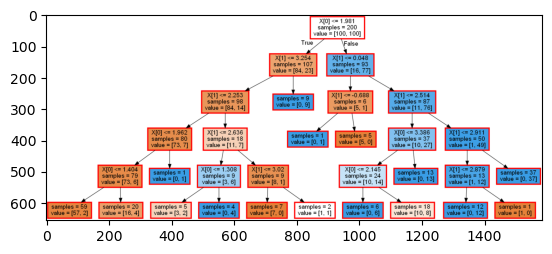

In [ ]:
plt.imshow(image.imread(your_path+'tree_src_h.png'))

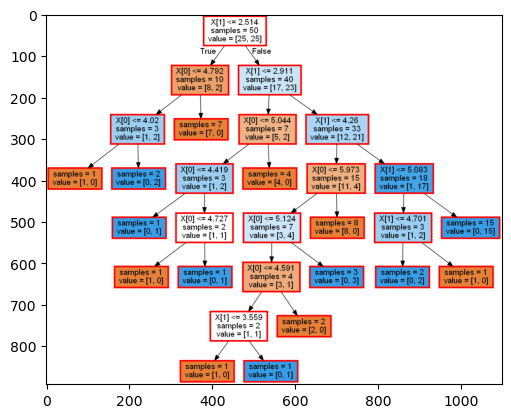

In [ ]:
plt.imshow(image.imread(your_path+'tree_ser_h.png'))

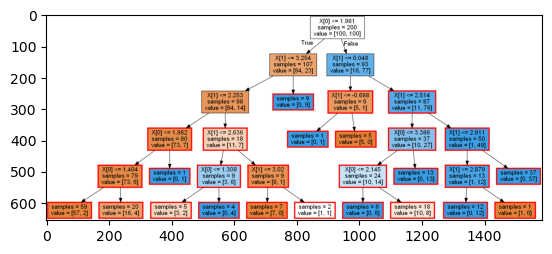

In [ ]:
plt.imshow(image.imread(your_path+'tree_src_h2.png'))

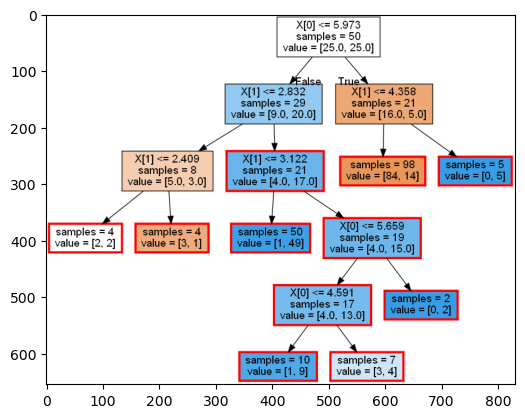

In [ ]:
plt.imshow(image.imread(your_path+'tree_strut_h.png'))

<h3>Example 3 : random forest for numerous gaussian clusters classification </h3><a name="rf_clust"></a>

In [ ]:
from generate_synth_utils import create_N_clusters, create_clusters, translate_N_clusters, shrink_N_clusters
from generate_synth_utils import delete_N_clusters, add_N_clusters, generate_samples

In [ ]:
np.random.seed(0)
N0=5
N1=5

n_source_by_c = 50
n_target_by_c = 10

means_src,sigs_src,classes_src = create_clusters(N0,N1,mean_range=[-5,5],sig_range=[0.5,2])
Xs,ys=generate_samples(n_source_by_c,means_src,sigs_src,classes_src)

#No change:
Xt,yt=generate_samples(n_target_by_c,means_src,sigs_src,classes_src)

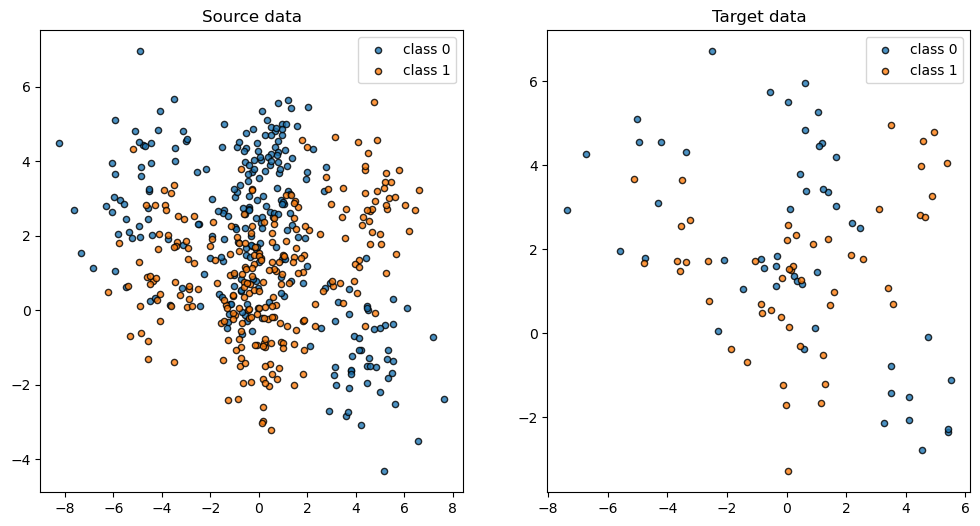

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

In [ ]:
MAX = 5
K_FOLD = 10
N_EST = 10

# Source and Target classifiers :
clf_source = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)
clf_target = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)


#K folds coss-validation:
skf = select.StratifiedKFold(n_splits=K_FOLD)

score_src = np.zeros(K_FOLD)
score_src_tgt = np.zeros(K_FOLD)
score_tgt_src = np.zeros(K_FOLD)
score_tgt = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xs, ys):
    X_src_train, Y_src_train, X_src_test, Y_src_test = Xs[train], ys[train], Xs[test], ys[test]
    clf_source.fit(X_src_train, Y_src_train)
    score_src[k] = clf_source.score(X_src_test, Y_src_test)
    score_src_tgt[k] = clf_source.score(Xt, yt)

    k+=1

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    clf_target.fit(X_tgt_train, Y_tgt_train)
    score_tgt[k] = clf_target.score(X_tgt_test, Y_tgt_test)
    score_tgt_src[k] = clf_target.score(Xs, ys)

    k+=1

print('Score Target model: {:.3f}'.format(np.mean(score_tgt)))
print('Score Source model: {:.3f}'.format(np.mean(score_src)))
print('Score Source model on Target: {:.3f}'.format(np.mean(score_src_tgt)))
#print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))

Score Target model: 0.660
Score Source model: 0.692
Score Source model on Target: 0.755


In [ ]:
clf_src = copy.deepcopy(clf_source)

strut_model = TransferForestClassifier(estimator=clf_src,algo="strut")
ser_model = TransferForestClassifier(estimator=clf_src,algo="ser")

score_strut= np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    strut_model.fit(X_tgt_train, Y_tgt_train)
    ser_model.fit(X_tgt_train, Y_tgt_train)
    score_strut[k] = strut_model.score(X_tgt_test, Y_tgt_test)
    score_ser[k] = ser_model.score(X_tgt_test, Y_tgt_test)

    k+=1

print('Score STRUT model: {:.3f}'.format(np.mean(score_strut)))
print('Score SER model: {:.3f}'.format(np.mean(score_ser)))

Score STRUT model: 0.700
Score SER model: 0.860


In [ ]:
algo_list = ['src','trgt','relab','ser','strut']
n_versions = len(algo_list)
DT_only = False
RF_SIZE = 10

auc_score_strf = np.zeros(K_FOLD)
auc_score_strut = np.zeros(K_FOLD)
auc_score_ser = np.zeros(K_FOLD)
auc_score_strf_src = np.zeros(K_FOLD)
auc_score_strut_src = np.zeros(K_FOLD)
auc_score_ser_src = np.zeros(K_FOLD)

score_strf = np.zeros(K_FOLD)
score_strut = np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

count_ind = np.zeros((K_FOLD,n_versions))

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]

    if DT_only:
        TTS = TransferTreeSelector(estimator=clf_source,algorithms=algo_list)
        TTS.fit(X_tgt_train,Y_tgt_train)
        strut_model = TTS.transferred_models[algo_list.index("strut")]
        ser_model = TTS.transferred_models[algo_list.index("ser")]

        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test)
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test)

    else:
        TFS = TransferForestSelector(estimator=clf_source,algorithms=algo_list)
        TFS.model_selection(X_tgt_train,Y_tgt_train,score_type="auc",oob_=True)
        score_strf[k] = TFS.STRF_model.score(X_tgt_test,Y_tgt_test)

        strut_model = TFS.transferred_models[algo_list.index("strut")]
        ser_model = TFS.transferred_models[algo_list.index("ser")]

        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test)
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test)

        auc_score_strf[k] = metr.roc_auc_score(Y_tgt_test,TFS.STRF_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_strut[k] = metr.roc_auc_score(Y_tgt_test,strut_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_ser[k] = metr.roc_auc_score(Y_tgt_test,ser_model.estimator_.predict_proba(X_tgt_test)[:,1])

        auc_score_strf_src[k] = metr.roc_auc_score(ys,TFS.STRF_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_strut_src[k] = metr.roc_auc_score(ys,strut_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_ser_src[k] = metr.roc_auc_score(ys,ser_model.estimator_.predict_proba(Xs)[:,1])

        counts = np.zeros(n_versions)
        for u in range(n_versions):
            counts[u] = list(TFS.STRF_indexes).count(u)
        count_ind[k] = counts/RF_SIZE
    k+=1

print('SCORES:')
print('    STRUT',np.mean(score_strut))
print('    SER',np.mean(score_ser))
print('    STRF',np.mean(score_strf))
print('AUC SCORES:')
print('    STRUT',np.mean(auc_score_strut))
print('    SER',np.mean(auc_score_ser))
print('    STRF',np.mean(auc_score_strf))
print('AUC SCORES ON SRC:')
print('    STRUT',np.mean(auc_score_strut_src))
print('    SER',np.mean(auc_score_ser_src))
print('    STRF',np.mean(auc_score_strf_src))

SCORES:
    STRUT 0.5799999999999998
    SER 0.6399999999999999
    STRF 0.67
AUC SCORES:
    STRUT 0.646
    SER 0.682
    STRF 0.624
AUC SCORES ON SRC:
    STRUT 0.676136
    SER 0.8004872000000001
    STRF 0.7805815999999999


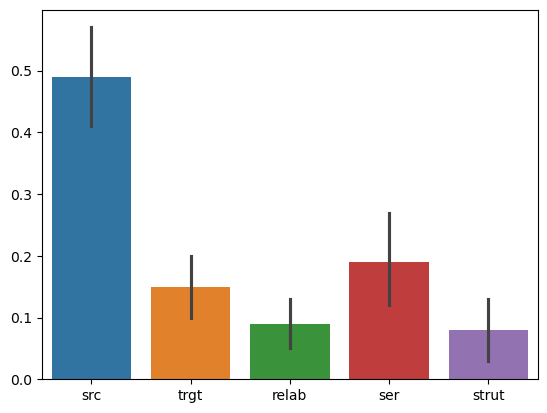

In [ ]:
df = pd.DataFrame(count_ind, columns = algo_list)
ax = sns.barplot(data=df)

#### Redrawing new clusters (no link between Source/Target) <a name="rf_tgt"></a>

In [ ]:
np.random.seed(0)
N0=5
N1=5

n_source_by_c = 50
n_target_by_c = 10

means_src,sigs_src,classes_src = create_clusters(N0,N1,mean_range=[-5,5],sig_range=[0.5,2])
Xs,ys=generate_samples(n_source_by_c,means_src,sigs_src,classes_src)

#No change:
means_tgt,sigs_tgt,classes_tgt = create_clusters(N0,N1,mean_range=[-5,5],sig_range=[0.5,2])
Xt,yt=generate_samples(n_target_by_c,means_tgt,sigs_tgt,classes_tgt)

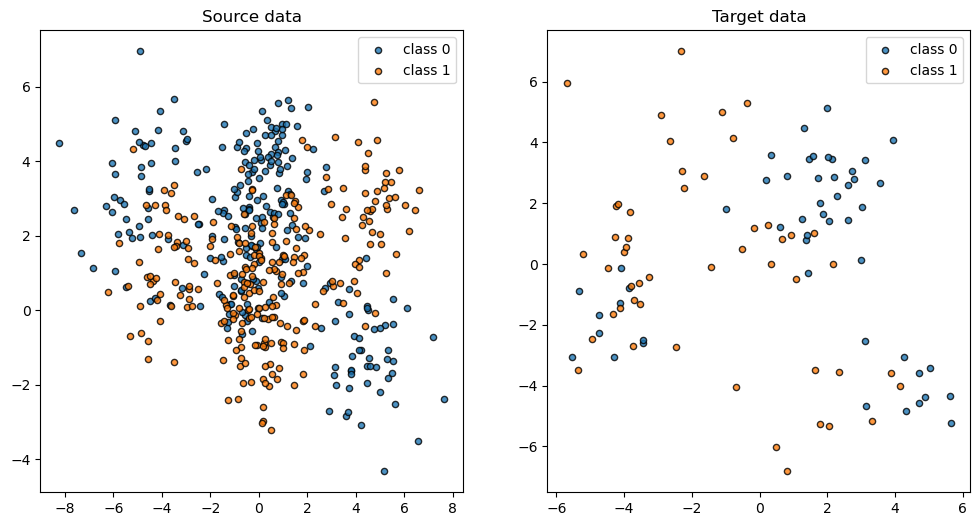

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

In [ ]:
MAX = 5
K_FOLD = 10
N_EST = 10

# Source and Target classifiers :
clf_source = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)
clf_target = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)


#K folds coss-validation:
skf = select.StratifiedKFold(n_splits=K_FOLD)

score_src = np.zeros(K_FOLD)
score_src_tgt = np.zeros(K_FOLD)
score_tgt_src = np.zeros(K_FOLD)
score_tgt = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xs, ys):
    X_src_train, Y_src_train, X_src_test, Y_src_test = Xs[train], ys[train], Xs[test], ys[test]
    clf_source.fit(X_src_train, Y_src_train)
    score_src[k] = clf_source.score(X_src_test, Y_src_test)
    score_src_tgt[k] = clf_source.score(Xt, yt)

    k+=1

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    clf_target.fit(X_tgt_train, Y_tgt_train)
    score_tgt[k] = clf_target.score(X_tgt_test, Y_tgt_test)
    score_tgt_src[k] = clf_target.score(Xs, ys)

    k+=1

print('Score Target model: {:.3f}'.format(np.mean(score_tgt)))
print('Score Source model: {:.3f}'.format(np.mean(score_src)))
print('Score Source model on Target: {:.3f}'.format(np.mean(score_src_tgt)))
#print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))

Score Target model: 0.690
Score Source model: 0.666
Score Source model on Target: 0.539


In [ ]:
clf_src = copy.deepcopy(clf_source)

strut_model = TransferForestClassifier(estimator=clf_src,algo="strut")
ser_model = TransferForestClassifier(estimator=clf_src,algo="ser")

score_strut= np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    strut_model.fit(X_tgt_train, Y_tgt_train)
    ser_model.fit(X_tgt_train, Y_tgt_train)
    score_strut[k] = strut_model.score(X_tgt_test, Y_tgt_test)
    score_ser[k] = ser_model.score(X_tgt_test, Y_tgt_test)

    k+=1

print('Score STRUT model: {:.3f}'.format(np.mean(score_strut)))
print('Score SER model: {:.3f}'.format(np.mean(score_ser)))

Score STRUT model: 0.750
Score SER model: 0.790


In [ ]:
algo_list = ['src','trgt','relab','ser','strut']
n_versions = len(algo_list)
DT_only = False
RF_SIZE = 10

auc_score_strf = np.zeros(K_FOLD)
auc_score_strut = np.zeros(K_FOLD)
auc_score_ser = np.zeros(K_FOLD)
auc_score_strf_src = np.zeros(K_FOLD)
auc_score_strut_src = np.zeros(K_FOLD)
auc_score_ser_src = np.zeros(K_FOLD)

score_strf = np.zeros(K_FOLD)
score_strut = np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

count_ind = np.zeros((K_FOLD,n_versions))

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]

    if DT_only:
        TTS = TransferTreeSelector(estimator=clf_source,algorithms=algo_list)
        TTS.fit(X_tgt_train,Y_tgt_train)
        strut_model = TTS.transferred_models[algo_list.index("strut")]
        ser_model = TTS.transferred_models[algo_list.index("ser")]

        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test)
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test)

    else:
        TFS = TransferForestSelector(estimator=clf_source,algorithms=algo_list)
        TFS.model_selection(X_tgt_train,Y_tgt_train,score_type="auc",oob_=True)
        score_strf[k] = TFS.STRF_model.score(X_tgt_test,Y_tgt_test)

        strut_model = TFS.transferred_models[algo_list.index("strut")]
        ser_model = TFS.transferred_models[algo_list.index("ser")]

        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test)
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test)

        auc_score_strf[k] = metr.roc_auc_score(Y_tgt_test,TFS.STRF_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_strut[k] = metr.roc_auc_score(Y_tgt_test,strut_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_ser[k] = metr.roc_auc_score(Y_tgt_test,ser_model.estimator_.predict_proba(X_tgt_test)[:,1])

        auc_score_strf_src[k] = metr.roc_auc_score(ys,TFS.STRF_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_strut_src[k] = metr.roc_auc_score(ys,strut_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_ser_src[k] = metr.roc_auc_score(ys,ser_model.estimator_.predict_proba(Xs)[:,1])

        counts = np.zeros(n_versions)
        for u in range(n_versions):
            counts[u] = list(TFS.STRF_indexes).count(u)
        count_ind[k] = counts/RF_SIZE
    k+=1

print('SCORES:')
print('    STRUT',np.mean(score_strut))
print('    SER',np.mean(score_ser))
print('    STRF',np.mean(score_strf))
print('AUC SCORES:')
print('    STRUT',np.mean(auc_score_strut))
print('    SER',np.mean(auc_score_ser))
print('    STRF',np.mean(auc_score_strf))
print('AUC SCORES ON SRC:')
print('    STRUT',np.mean(auc_score_strut_src))
print('    SER',np.mean(auc_score_ser_src))
print('    STRF',np.mean(auc_score_strf_src))

SCORES:
    STRUT 0.62
    SER 0.65
    STRF 0.68
AUC SCORES:
    STRUT 0.586
    SER 0.798
    STRF 0.6559999999999999
AUC SCORES ON SRC:
    STRUT 0.6217400000000001
    SER 0.4954967999999999
    STRF 0.604648


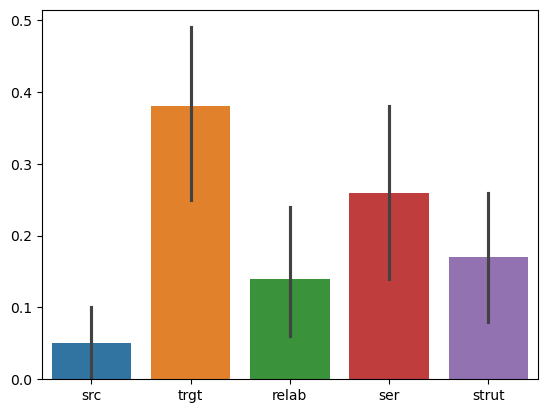

In [ ]:
df = pd.DataFrame(count_ind, columns = algo_list)
ax = sns.barplot(data=df)

#### Translations between Source and Target <a name="rf_translation"></a>

In [ ]:
np.random.seed(0)
N0=5
N1=5

n_source_by_c = 50
n_target_by_c = 10

means_src,sigs_src,classes_src = create_clusters(N0,N1,mean_range=[-5,5],sig_range=[0.5,2])
Xs,ys=generate_samples(n_source_by_c,means_src,sigs_src,classes_src)

#Translation:
means,sigs,classes = translate_N_clusters(4,means_src,sigs_src,classes_src,mean_range=[-5,5],sig_range=[0.5,2])
Xt,yt=generate_samples(n_target_by_c,means,sigs,classes)

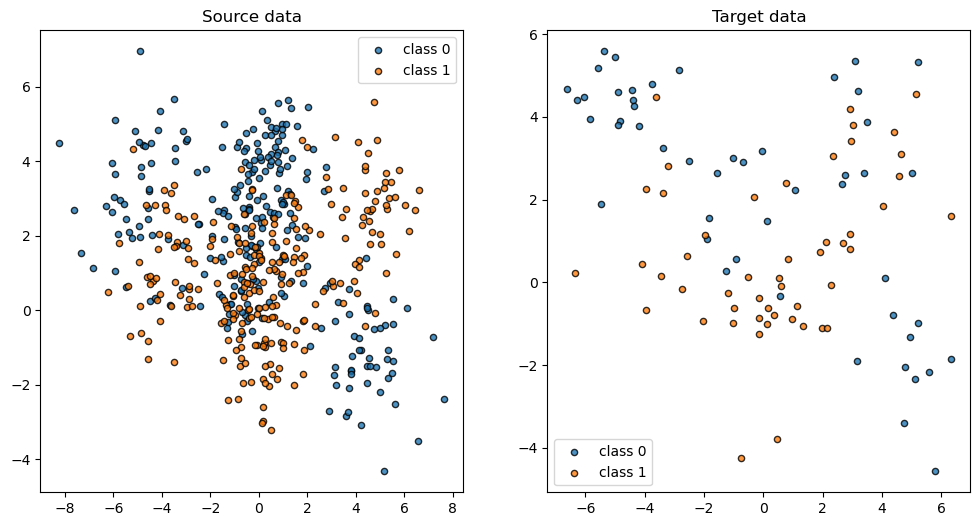

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

In [ ]:
MAX = 5
K_FOLD = 10
N_EST = 10

# Source and Target classifiers :
clf_source = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)
clf_target = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)


#K folds coss-validation:
skf = select.StratifiedKFold(n_splits=K_FOLD)

score_src = np.zeros(K_FOLD)
score_src_tgt = np.zeros(K_FOLD)
score_tgt_src = np.zeros(K_FOLD)
score_tgt = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xs, ys):
    X_src_train, Y_src_train, X_src_test, Y_src_test = Xs[train], ys[train], Xs[test], ys[test]
    clf_source.fit(X_src_train, Y_src_train)
    score_src[k] = clf_source.score(X_src_test, Y_src_test)
    score_src_tgt[k] = clf_source.score(Xt, yt)

    k+=1

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    clf_target.fit(X_tgt_train, Y_tgt_train)
    score_tgt[k] = clf_target.score(X_tgt_test, Y_tgt_test)
    score_tgt_src[k] = clf_target.score(Xs, ys)

    k+=1

print('Score Target model: {:.3f}'.format(np.mean(score_tgt)))
print('Score Source model: {:.3f}'.format(np.mean(score_src)))
print('Score Source model on Target: {:.3f}'.format(np.mean(score_src_tgt)))
#print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))

Score Target model: 0.700
Score Source model: 0.714
Score Source model on Target: 0.804


In [ ]:
clf_src = copy.deepcopy(clf_source)

strut_model = TransferForestClassifier(estimator=clf_src,algo="strut")
ser_model = TransferForestClassifier(estimator=clf_src,algo="ser")

score_strut= np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    strut_model.fit(X_tgt_train, Y_tgt_train)
    ser_model.fit(X_tgt_train, Y_tgt_train)
    score_strut[k] = strut_model.score(X_tgt_test, Y_tgt_test)
    score_ser[k] = ser_model.score(X_tgt_test, Y_tgt_test)

    k+=1

print('Score STRUT model: {:.3f}'.format(np.mean(score_strut)))
print('Score SER model: {:.3f}'.format(np.mean(score_ser)))

Score STRUT model: 0.580
Score SER model: 0.810


In [ ]:
algo_list = ['src','trgt','relab','ser','strut']
n_versions = len(algo_list)
DT_only = False
RF_SIZE = 10

auc_score_strf = np.zeros(K_FOLD)
auc_score_strut = np.zeros(K_FOLD)
auc_score_ser = np.zeros(K_FOLD)
auc_score_strf_src = np.zeros(K_FOLD)
auc_score_strut_src = np.zeros(K_FOLD)
auc_score_ser_src = np.zeros(K_FOLD)

score_strf = np.zeros(K_FOLD)
score_strut = np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

count_ind = np.zeros((K_FOLD,n_versions))

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]

    if DT_only:
        TTS = TransferTreeSelector(estimator=clf_source,algorithms=algo_list)
        TTS.fit(X_tgt_train,Y_tgt_train)
        strut_model = TTS.transferred_models[algo_list.index("strut")]
        ser_model = TTS.transferred_models[algo_list.index("ser")]

        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test)
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test)

    else:
        TFS = TransferForestSelector(estimator=clf_source,algorithms=algo_list)
        TFS.model_selection(X_tgt_train,Y_tgt_train,score_type="auc",oob_=True)
        score_strf[k] = TFS.STRF_model.score(X_tgt_test,Y_tgt_test)

        strut_model = TFS.transferred_models[algo_list.index("strut")]
        ser_model = TFS.transferred_models[algo_list.index("ser")]

        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test)
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test)

        auc_score_strf[k] = metr.roc_auc_score(Y_tgt_test,TFS.STRF_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_strut[k] = metr.roc_auc_score(Y_tgt_test,strut_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_ser[k] = metr.roc_auc_score(Y_tgt_test,ser_model.estimator_.predict_proba(X_tgt_test)[:,1])

        auc_score_strf_src[k] = metr.roc_auc_score(ys,TFS.STRF_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_strut_src[k] = metr.roc_auc_score(ys,strut_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_ser_src[k] = metr.roc_auc_score(ys,ser_model.estimator_.predict_proba(Xs)[:,1])

        counts = np.zeros(n_versions)
        for u in range(n_versions):
            counts[u] = list(TFS.STRF_indexes).count(u)
        count_ind[k] = counts/RF_SIZE
    k+=1

print('SCORES:')
print('    STRUT',np.mean(score_strut))
print('    SER',np.mean(score_ser))
print('    STRF',np.mean(score_strf))
print('AUC SCORES:')
print('    STRUT',np.mean(auc_score_strut))
print('    SER',np.mean(auc_score_ser))
print('    STRF',np.mean(auc_score_strf))
print('AUC SCORES ON SRC:')
print('    STRUT',np.mean(auc_score_strut_src))
print('    SER',np.mean(auc_score_ser_src))
print('    STRF',np.mean(auc_score_strf_src))

SCORES:
    STRUT 0.63
    SER 0.71
    STRF 0.6599999999999999
AUC SCORES:
    STRUT 0.756
    SER 0.778
    STRF 0.776
AUC SCORES ON SRC:
    STRUT 0.7080128
    SER 0.7902647999999999
    STRF 0.75034


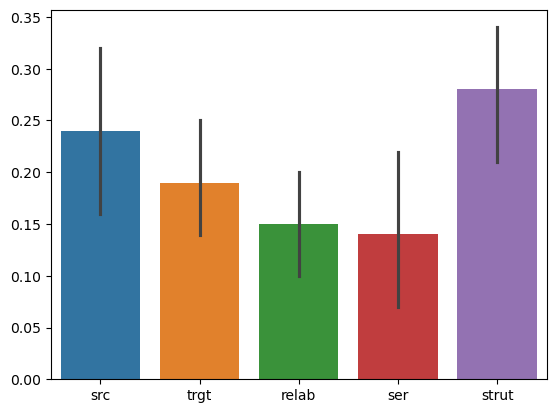

In [ ]:
df = pd.DataFrame(count_ind, columns = algo_list)
ax = sns.barplot(data=df)

#### Addition/deletion of clusters <a name="rf_add_del"></a>

In [ ]:
np.random.seed(0)

N0 = 10
N1 = 10

n_source_by_c = 50
n_target_by_c = 10

means_src,sigs_src,classes_src = create_clusters(N0,N1,mean_range=[-5,5],sig_range=[0.5,2])
Xs,ys=generate_samples(n_source_by_c,means_src,sigs_src,classes_src)

#Addition/deletion:
means1,sigs1,classes1 = add_N_clusters(3,1,means_src,sigs_src,classes_src,mean_range=[-7,7],sig_range=[0.5,1])
means2,sigs2,classes2 = add_N_clusters(3,0,means1,sigs1,classes1,mean_range=[-7,7],sig_range=[0.5,1])
means,sigs,classes = delete_N_clusters(2,means2,sigs2,classes2)

Xt,yt=generate_samples(n_target_by_c,means,sigs,classes)

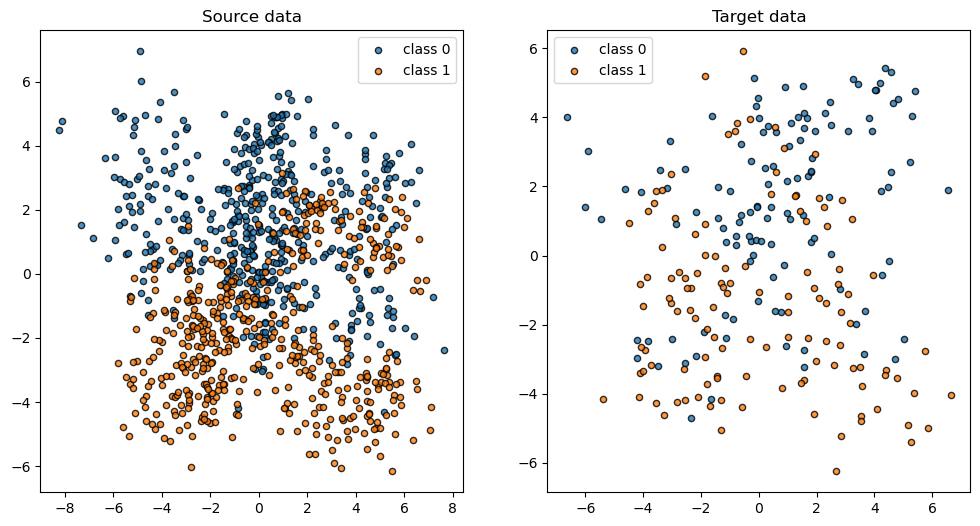

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

In [ ]:
MAX = 5
K_FOLD = 10
N_EST = 10

# Source and Target classifiers :
clf_source = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)
clf_target = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)


#K folds coss-validation:
skf = select.StratifiedKFold(n_splits=K_FOLD)

score_src = np.zeros(K_FOLD)
score_src_tgt = np.zeros(K_FOLD)
score_tgt_src = np.zeros(K_FOLD)
score_tgt = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xs, ys):
    X_src_train, Y_src_train, X_src_test, Y_src_test = Xs[train], ys[train], Xs[test], ys[test]
    clf_source.fit(X_src_train, Y_src_train)
    score_src[k] = clf_source.score(X_src_test, Y_src_test)
    score_src_tgt[k] = clf_source.score(Xt, yt)

    k+=1

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    clf_target.fit(X_tgt_train, Y_tgt_train)
    score_tgt[k] = clf_target.score(X_tgt_test, Y_tgt_test)
    score_tgt_src[k] = clf_target.score(Xs, ys)

    k+=1

print('Score Target model: {:.3f}'.format(np.mean(score_tgt)))
print('Score Source model: {:.3f}'.format(np.mean(score_src)))
print('Score Source model on Target: {:.3f}'.format(np.mean(score_src_tgt)))
#print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))

Score Target model: 0.663
Score Source model: 0.665
Score Source model on Target: 0.724


In [ ]:
clf_src = copy.deepcopy(clf_source)

strut_model = TransferForestClassifier(estimator=clf_src,algo="strut")
ser_model = TransferForestClassifier(estimator=clf_src,algo="ser")

score_strut= np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    strut_model.fit(X_tgt_train, Y_tgt_train)
    ser_model.fit(X_tgt_train, Y_tgt_train)
    score_strut[k] = strut_model.score(X_tgt_test, Y_tgt_test)
    score_ser[k] = ser_model.score(X_tgt_test, Y_tgt_test)

    k+=1

print('Score STRUT model: {:.3f}'.format(np.mean(score_strut)))
print('Score SER model: {:.3f}'.format(np.mean(score_ser)))

Score STRUT model: 0.746
Score SER model: 0.725


In [ ]:
algo_list = ['src','target','relab','ser','strut']
n_versions = len(algo_list)

auc_score_strf = np.zeros(K_FOLD)
auc_score_strut = np.zeros(K_FOLD)
auc_score_ser = np.zeros(K_FOLD)
auc_score_strf_src = np.zeros(K_FOLD)
auc_score_strut_src = np.zeros(K_FOLD)
auc_score_ser_src = np.zeros(K_FOLD)

score_strf = np.zeros(K_FOLD)
score_strut = np.zeros(K_FOLD)
score_ser = np.zeros(K_FOLD)

count_ind = np.zeros((K_FOLD,n_versions))

k=0
for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]

    if DT_only:
        TTS = TransferTreeSelector(estimator=clf_source,algorithms=algo_list)
        TTS.fit(X_tgt_train,Y_tgt_train)
        strut_model = TTS.transferred_models[algo_list.index("strut")]
        ser_model = TTS.transferred_models[algo_list.index("ser")]

        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test)
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test)

    else:
        TFS = TransferForestSelector(estimator=clf_source,algorithms=algo_list)
        TFS.model_selection(X_tgt_train,Y_tgt_train,score_type="auc",oob_=True)
        score_strf[k] = TFS.STRF_model.score(X_tgt_test,Y_tgt_test)

        strut_model = TFS.transferred_models[algo_list.index("strut")]
        ser_model = TFS.transferred_models[algo_list.index("ser")]

        score_strut[k] = strut_model.score(X_tgt_test,Y_tgt_test)
        score_ser[k] = ser_model.score(X_tgt_test,Y_tgt_test)

        auc_score_strf[k] = metr.roc_auc_score(Y_tgt_test,TFS.STRF_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_strut[k] = metr.roc_auc_score(Y_tgt_test,strut_model.estimator_.predict_proba(X_tgt_test)[:,1])
        auc_score_ser[k] = metr.roc_auc_score(Y_tgt_test,ser_model.estimator_.predict_proba(X_tgt_test)[:,1])

        auc_score_strf_src[k] = metr.roc_auc_score(ys,TFS.STRF_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_strut_src[k] = metr.roc_auc_score(ys,strut_model.estimator_.predict_proba(Xs)[:,1])
        auc_score_ser_src[k] = metr.roc_auc_score(ys,ser_model.estimator_.predict_proba(Xs)[:,1])

        counts = np.zeros(n_versions)
        for u in range(n_versions):
            counts[u] = list(TFS.STRF_indexes).count(u)
        count_ind[k] = counts/RF_SIZE
    k+=1

print('SCORES:')
print('    STRUT',np.mean(score_strut))
print('    SER',np.mean(score_ser))
print('    STRF',np.mean(score_strf))
print('AUC SCORES:')
print('    STRUT',np.mean(auc_score_strut))
print('    SER',np.mean(auc_score_ser))
print('    STRF',np.mean(auc_score_strf))
print('AUC SCORES ON SRC:')
print('    STRUT',np.mean(auc_score_strut_src))
print('    SER',np.mean(auc_score_ser_src))
print('    STRF',np.mean(auc_score_strf_src))

SCORES:
    STRUT 0.6833333333333333
    SER 0.6416666666666667
    STRF 0.7125
AUC SCORES:
    STRUT 0.5965277777777778
    SER 0.7215277777777777
    STRF 0.6857638888888888
AUC SCORES ON SRC:
    STRUT 0.6945631999999999
    SER 0.7856386
    STRF 0.8271124000000001


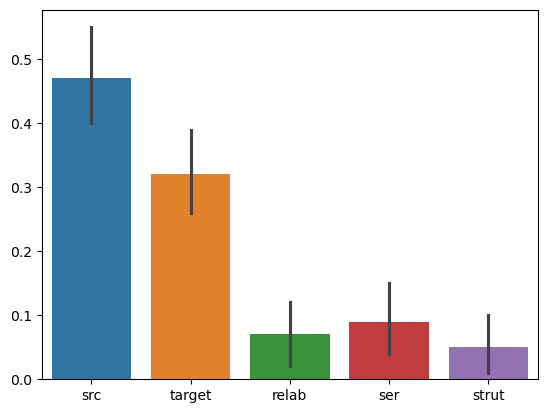

In [ ]:
df = pd.DataFrame(count_ind, columns = algo_list)
ax = sns.barplot(data=df)